# GAN architecture test lab
This file is building the GAN architecture and making sure, that the sizes/shapes are correct

In [41]:
# imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

import torchvision

from utils import *
import clip

from dataloader import SketchImageDataLoader

In [2]:
# make cuda available
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
print('using device:', device)

using device: cuda


## Dataloader

In [3]:
dataloader = SketchImageDataLoader("./../dataset/")

In [6]:
dataloader[0]['resized'].shape

(224, 224, 3)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


[]

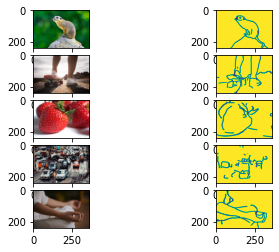

In [4]:
# verify the right dataloader
fig, ax = plt.subplots(max(len(dataloader), 5), 2)

for i in range(max(len(dataloader), 5)):
    sample = dataloader[i]
    ax[i, 0].imshow(sample['image'])
    ax[i, 1].imshow(sample['sketch'])

plt.plot()

## GAN

In [62]:
# test CLIP
img = dataloader[0]

model, preprocess = clip.load("ViT-B/32", device=device)

with torch.no_grad():
    image_features = model.encode_image(torch.tensor(img['resized'].reshape((1, 3, 224, 224))).to(device))
    print(image_features.shape)

torch.Size([1, 512])


In [110]:
class ImageCompressor(nn.Module):
    """
    Image compressor in order to retain local information for the GAN

    Input: Image (240x360)
    Output: Vector (1x512)
    """

    def __init__(self):
        super(ImageCompressor, self).__init__()

        layers = [
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.MaxPool2d(kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.Flatten(0, 2)
        ]

        self.layers = nn.Sequential(*layers)

    def forward(self, image):
        image = torchvision.transforms.functional.to_tensor(image.numpy())
        return self.layers(image)


# compressor = ImageCompressor()
# print('parameters:', sum(p.numel() for p in compressor.parameters()))
# compressor.forward(img['sketch']).shape

parameters: 23296


torch.Size([512])

In [59]:
image_size = (240, 360)
CLIP_latent_space = 512


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

    def forward(self, sketch, sketch_resized):
        # encode clip

        sketch = torch.tensor(sketch.reshape(1, 3, 240, 360)).to(device)
        # img['resized'].reshape((1, 3, 224, 224))
        with torch.no_grad():
            latent_space = model.encode_image(torch.tensor(sketch_resized).to(device))  # (1, 512)

        # noise
        noise = torch.randn((1, 512)).to(device)

        m = nn.Flatten(0, 3)  # 50 176

        gray = torchvision.transforms.Grayscale()

        flatten = gray(sketch)
        flatten = m(flatten)

        print(latent_space.shape, noise.shape, flatten.shape, sketch.shape)

        return torch.cat((latent_space.reshape(512), noise.reshape(512), flatten))

In [60]:
generator = Generator()

generator.forward(img['image'], img['resized'].reshape((1, 3, 224, 224))).shape

torch.Size([1, 512]) torch.Size([1, 512]) torch.Size([86400]) torch.Size([1, 3, 240, 360])


C:\Users\felix\AppData\Local\Temp\ipykernel_3056\4214343296.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sketch = torch.tensor(sketch.reshape(1, 3, 240, 360)).to(device)


torch.Size([87424])